In [24]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.cluster import KMeans
# import re
# import string
# import pandas as pd
# all_text  = """
#  Google and Facebook are strangling the free press to death. Democracy is the loserGoogle an 
# Your 60-second guide to security stuff Google touted today at Next '18
# A Guide to Using Android Without Selling Your Soul to Google
# Review: Lenovo’s Google Smart Display is pretty and intelligent
# Google Maps user spots mysterious object submerged off the coast of Greece - and no-one knows what it is
# Android is better than IOS
# In information retrieval, tf–idf or TFIDF, short for term frequency–inverse document frequency
# is a numerical statistic that is intended to reflect
# how important a word is to a document in a collection or corpus.
# It is often used as a weighting factor in searches of information retrieval
# text mining, and user modeling. The tf-idf value increases proportionally
# to the number of times a word appears in the document
# and is offset by the frequency of the word in the corpus
# """.split("\n")[1:-1]

# # Preprocessing and tokenizing
# def preprocessing(line):
#     line = line.lower()
#     line = re.sub(r"[{}]".format(string.punctuation), " ", line)
#     return line

In [29]:
# tfidf_vectorizer = TfidfVectorizer(preprocessor=preprocessing)

# tfidf = tfidf_vectorizer.fit_transform(all_text)

# kmeans = KMeans(n_clusters=2).fit(tfidf)

In [30]:
# lines_for_predicting = ["tf and idf is awesome!", "some androids is there"]
# kmeans.predict(tfidf_vectorizer.transform(lines_for_predicting))

array([0, 1])

_________________________________________________

### FEATURE ENGINEERING

In [4]:
import pandas as pd
clean_df= pd.read_csv('upd_clean_df.csv')
clean_df.drop('Unnamed: 0',inplace = True,axis = 1)
clean_df.shape

(649, 17)

In [5]:

clean_df = clean_df[~clean_df.clean_text.isnull()]
# clean_df[clean_df.clean_text.isnull()].shape
clean_df.shape

(638, 17)

In [6]:
# TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
final_tf_idf = tf_idf_vect.fit_transform(clean_df['clean_text'].values)

# bow_vect = CountVectorizer(ngram_range=(1,2))
# bag_of_words = count_vectorizer.fit_transform(clean_df['clean_text'])

In [7]:
print(final_tf_idf.shape)

(638, 4309)


In [8]:
# добавление tfidf в матрицу фичей
feature_names = tf_idf_vect.get_feature_names()
feature_df = pd.DataFrame(final_tf_idf.toarray(), columns = feature_names)
feature_df.shape

(638, 4309)

In [9]:
# вероятность городов
def city_proba(city):
    if type(city) != str:
        return clean_df[clean_df['location'].isna()]['location'].shape[0]/clean_df.shape[0]
    else:
        proba = clean_df.location.value_counts()/clean_df.shape[0]
    return proba[city]

city_proba('Stockholm, Sweden')


0.034482758620689655

In [10]:
# проверка количества строк
clean_df[clean_df['location'].isna()]['location'].shape[0]+clean_df.location.value_counts().sum()

638

In [11]:
clean_df['location_proba'] = clean_df['location'].apply(lambda x:city_proba(x))
location_proba = list(clean_df['location_proba'])
feature_df['location_proba'] = location_proba



In [12]:
feature_df[feature_df['location_proba'].isna()].shape

(0, 4310)

### RFM analysis

In [13]:
clean_df.head(3)

,screen_name,carrier,location,date_time,clean_text,polarity,fact,month,hour,sense_dummy,text_len,day,day_of_month,part_of_day,seconds,sin_time,cos_time,location_proba
0,TheSkubis,verizonsupport,"Pennsylvania, USA",2021-03-30 23:59:19,issue closed caption walking dead show display...,-0.150,1,3,23,-1,51,1,30,evening,19,0.001382,0.999999,0.003135
1,VerizonSupport,verizonsupport,NaN,2021-03-30 23:56:55,this could due regional restriction have check...,-0.125,1,3,23,-1,52,1,30,evening,55,0.004000,0.999992,0.412226
2,VerizonSupport,verizonsupport,NaN,2021-03-30 23:55:30,happy help anything related fios twitter pleas...,0.400,0,3,23,1,63,1,30,evening,30,0.002182,0.999998,0.412226


In [14]:
feature_df.head(3)

,able,able get,able help,able redeem,able watch,absolutely,absolutely horrendous,absolutely suck,acce,access,...,ypr,ypr yard,yr,yr ago,zip,zip code,𝐋𝐄𝐀𝐃𝐄𝐑,𝐓𝐇𝐄,𝐓𝐇𝐄 𝐋𝐄𝐀𝐃𝐄𝐑,location_proba
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003135
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.412226
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.412226


In [15]:
import datetime as dt
import re
clean_df['datetime'] = clean_df['date_time'].apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
clean_df['datetime'] = clean_df['datetime'].apply(dt.datetime.date)


In [16]:
recency = list(clean_df['datetime'].apply(lambda x: dt.date.today() - x))
recency
feature_df['recency'] = recency
feature_df['recency'] = feature_df['recency'].apply(lambda x: int(str(x).split()[0]))
feature_df[feature_df['recency'] == 'NaT']

,able,able get,able help,able redeem,able watch,absolutely,absolutely horrendous,absolutely suck,acce,access,...,ypr yard,yr,yr ago,zip,zip code,𝐋𝐄𝐀𝐃𝐄𝐑,𝐓𝐇𝐄,𝐓𝐇𝐄 𝐋𝐄𝐀𝐃𝐄𝐑,location_proba,recency


In [503]:
# feature_df[feature_df['location_proba'].isna()]

In [17]:
# feature_df['frequency'] = f
frequency = list(clean_df['screen_name'].apply(lambda x: clean_df[clean_df['screen_name'] == x].shape[0]))
feature_df['frequency'] = frequency
clean_df['frequency'] = clean_df['screen_name'].apply(lambda x: clean_df[clean_df['screen_name'] == x].shape[0])

In [18]:
monetary = list(clean_df['polarity'])
feature_df['monetary'] = monetary
feature_df.head(3)

,able,able get,able help,able redeem,able watch,absolutely,absolutely horrendous,absolutely suck,acce,access,...,yr ago,zip,zip code,𝐋𝐄𝐀𝐃𝐄𝐑,𝐓𝐇𝐄,𝐓𝐇𝐄 𝐋𝐄𝐀𝐃𝐄𝐑,location_proba,recency,frequency,monetary
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.003135,15,1,-0.150
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.412226,15,38,-0.125
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.412226,15,38,0.400


In [19]:
# recency
r_q3 = feature_df['recency'].quantile(0.3)
r_q6 = feature_df['recency'].quantile(0.6)

feature_df['r'] = feature_df['recency'].apply(lambda x: 1 if x < r_q3 else(2 if r_q3<x<r_q6 else 3)  )
# frequency
f_q3 = feature_df['frequency'].quantile(0.3)
f_q6 = feature_df['frequency'].quantile(0.6)

feature_df['f'] = feature_df['frequency'].apply(lambda x: 1 if x < f_q3 else(2 if f_q3<x<f_q6 else 3)  )

# monetary
m_q3 = feature_df['monetary'].quantile(0.3)
m_q6 = feature_df['monetary'].quantile(0.6)

feature_df['m'] = feature_df['monetary'].apply(lambda x: 1 if x < m_q3 else(2 if m_q3<x<m_q6 else 3)  )
feature_df['rfm'] = feature_df['r']*100 + feature_df['f']*10 + feature_df['m']

In [20]:
# feature_df.drop(['r','f','m'],inplace = True,axis = 1)
feature_df.drop(['recency','frequency','monetary'],inplace = True,axis = 1)
feature_df

,able,able get,able help,able redeem,able watch,absolutely,absolutely horrendous,absolutely suck,acce,access,...,zip,zip code,𝐋𝐄𝐀𝐃𝐄𝐑,𝐓𝐇𝐄,𝐓𝐇𝐄 𝐋𝐄𝐀𝐃𝐄𝐑,location_proba,r,f,m,rfm
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.003135,3,3,1,331
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.412226,3,3,1,331
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.412226,3,3,3,333
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.412226,3,3,3,333
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.412226,3,3,3,333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.001567,3,3,3,333
634,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.089342,3,3,3,333
635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.089342,3,3,3,333
636,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.089342,3,3,3,333


In [21]:
sin  = list(clean_df['sin_time'])
cos = list(clean_df['cos_time'])

feature_df['sin_time'] = sin
feature_df['cos_time'] = cos

In [22]:
feature_df.head()

,able,able get,able help,able redeem,able watch,absolutely,absolutely horrendous,absolutely suck,acce,access,...,𝐋𝐄𝐀𝐃𝐄𝐑,𝐓𝐇𝐄,𝐓𝐇𝐄 𝐋𝐄𝐀𝐃𝐄𝐑,location_proba,r,f,m,rfm,sin_time,cos_time
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.003135,3,3,1,331,0.001382,0.999999
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.412226,3,3,1,331,0.004000,0.999992
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.412226,3,3,3,333,0.002182,0.999998
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.412226,3,3,3,333,0.001745,0.999998
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.412226,3,3,3,333,0.001891,0.999998


### CLUSTERING

### здесь только fit?

In [23]:
num_clusters = 2

# Метод к-средних - KMeans
from sklearn.cluster import KMeans

km = KMeans(n_clusters=num_clusters)
print(km)
# get_ipython().magic('time km.fit(tfidf_matrix)')
idx = km.fit(feature_df)
# print(km.labels_)
clean_df['kmeans_churn'] = km.labels_
# clusters = km.labels_.tolist()
clean_df.head(2)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)


,screen_name,carrier,location,date_time,clean_text,polarity,fact,month,hour,sense_dummy,...,day,day_of_month,part_of_day,seconds,sin_time,cos_time,location_proba,datetime,frequency,kmeans_churn
0,TheSkubis,verizonsupport,"Pennsylvania, USA",2021-03-30 23:59:19,issue closed caption walking dead show display...,-0.150,1,3,23,-1,...,1,30,evening,19,0.001382,0.999999,0.003135,2021-03-30,1,1
1,VerizonSupport,verizonsupport,NaN,2021-03-30 23:56:55,this could due regional restriction have check...,-0.125,1,3,23,-1,...,1,30,evening,55,0.004000,0.999992,0.412226,2021-03-30,38,1


In [24]:
clean_df['kmeans_churn'].value_counts()

1    544
0     94
Name: kmeans_churn, dtype: int64

### накидаем простенькие модельки на 2 случая - когда у нас данные размечены кластеризациией и когда размечены исходя из полярности

In [25]:
# split with kmeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

km_train_x, km_valid_x, km_train_y, km_valid_y = \
    train_test_split(feature_df, clean_df['kmeans_churn'], \
    test_size=0.2, random_state=45)

In [189]:
# split with manual targeting by polarity <-0.5
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import LabelEncoder

# m_train_x, m_valid_x, m_train_y, m_valid_y = \
#     train_test_split(final_tf_idf, clean_df['churn'], \
#     test_size=0.2, random_state=45)

In [26]:
print(km_train_y.value_counts()/km_train_y.shape[0])
print(km_valid_y.value_counts()/km_valid_y.shape[0])

1    0.854902
0    0.145098
Name: kmeans_churn, dtype: float64
1    0.84375
0    0.15625
Name: kmeans_churn, dtype: float64


In [191]:
# print(m_train_y.value_counts()/m_train_y.shape[0])
# print(m_valid_y.value_counts()/m_valid_y.shape[0])

0    0.994118
1    0.005882
Name: churn, dtype: float64
0    0.984375
1    0.015625
Name: churn, dtype: float64


In [27]:
# для k-means данных
from sklearn.linear_model import LogisticRegression
km_lr = LogisticRegression()
km_lr.fit(km_train_x,km_train_y)
km_y_pred_lr =km_lr.predict(km_valid_x)


from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
print('для логистической регрессии', roc_auc_score(km_valid_y, km_y_pred_lr))

для логистической регрессии 1.0


C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [1]:
# def plot_precision_recall_curve(y_pred_proba, y_test):
#     plt.figure(figsize=(10, 10))
#     f_scores = np.linspace(0.4, 0.9, num=6)
#     lines = []
#     labels = []
#     for f_score in f_scores:
#         x = np.linspace(0.01, 1)
#         y = f_score * x / (2 * x - f_score)
#         l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
#         plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
#     precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

#     plt.step(recall, precision, color='b', alpha=0.2, where='post')
#     plt.fill_between(recall, precision, step='post', alpha=0.2,
#                      color='b')
#     plt.xlabel('Recall', size=15)
#     plt.ylabel('Precision', size=15)
#     plt.title('Precision-Recall curve', size=18)
#     plt.xlim([0.0, 1.0])
#     plt.ylim([0.0, 1.05])
#     plt.show()

# plot_precision_recall_curve(km_lr.predict_proba(km_valid_x),km_valid_y)

NameError: name 'km_lr' is not defined

In [205]:
# для manual targeted данных
# from sklearn.linear_model import LogisticRegression
# m_lr = LogisticRegression()
# m_lr.fit(m_train_x,m_train_y)
# m_y_pred_lr =m_lr.predict(mvalid_x)


# from sklearn.metrics import roc_auc_score,precision_recall_curve,roc_curve
# print('для логистической регрессии', roc_auc_score(m_valid_y, m_y_pred_lr))

для логистической регрессии 0.5


In [530]:
# confusion_matrix - Воспользуемся функцией построения матрицы ошибок из документации sklearn

import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')



C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Confusion matrix, without normalization
[[ 10  10]
 [  0 108]]


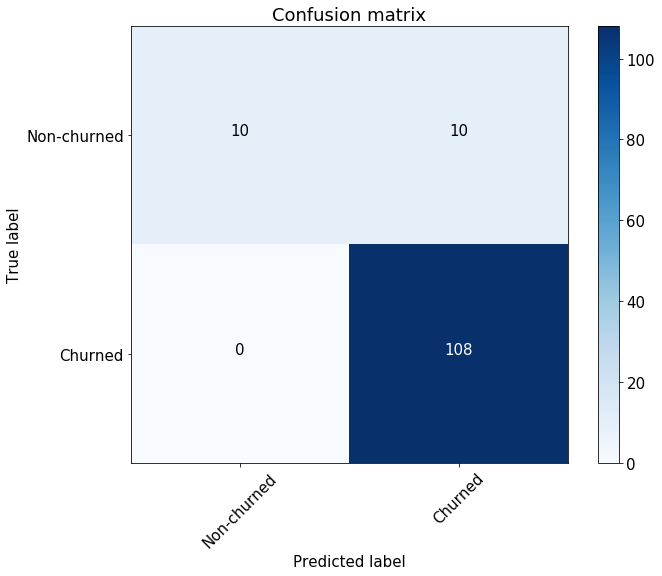

In [532]:
# для k_means данных
km_lr = LogisticRegression(random_state=42)
km_lr.fit(km_train_x, km_train_y)
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(km_valid_y, km_lr.predict(km_valid_x))
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [533]:
# для ручных данных
# m_lr = LogisticRegression(random_state=42)
# m_lr.fit(m_train_x, m_train_y)
# font = {'size' : 15}

# plt.rc('font', **font)

# cnf_matrix = confusion_matrix(m_valid_y, m_lr.predict(m_valid_x))
# plt.figure(figsize=(10, 8))
# plot_confusion_matrix(cnf_matrix, classes=['Non-churned', 'Churned'],
#                       title='Confusion matrix')
# plt.savefig("conf_matrix.png")
# plt.show()

In [534]:
# Classification Models and Success metrics
  
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
  
def model(classifier, train_vector, valid_vector,train_y,valid_y):
    classifier.fit(train_vector, train_y)  
    predict_y = classifier.predict(valid_vector)
    accuracy = accuracy_score(valid_y, predict_y)
    precision = precision_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    recall = recall_score(valid_y, predict_y,labels=[0,1,2,3,4,5,6],average=None)
    conf_matrix = confusion_matrix(valid_y, predict_y)
    print('\nAccuracy_score: {:.3f}'.format(accuracy ))
    print('precision_score: {:.3f}'.format(precision.mean()))
    print('recall_score: {:.3f}'.format(recall.mean()))
    print('\nconfusion_matrix: \n')
    
    print(confusion_matrix(valid_y, predict_y))
    print(classification_report(valid_y, predict_y))
    return roc_auc_pic(predict_y, valid_y),plot_precision_recall_curve(predict_y, valid_y)


In [535]:
# roc_auc_pic
import matplotlib.pyplot as plt 
def roc_auc_pic(y_hat_test, y_test):    
    fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_hat_test)
    roc_auc_test = roc_auc_score(y_test, y_hat_test)

    plt.rcParams['figure.figsize'] = (8, 8)
    plt.plot(fpr_test, tpr_test, label='Test ROC AUC {0}'.format(roc_auc_test))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.show() 
    pass
# roc_auc_pic(y_pred_lr, valid_y)


In [536]:
# precision_recall
import numpy as np
def plot_precision_recall_curve(y_pred_proba, y_test):
    plt.figure(figsize=(10, 10))
    f_scores = np.linspace(0.4, 0.9, num=6)
    lines = []
    labels = []
    for f_score in f_scores:
        x = np.linspace(0.01, 1)
        y = f_score * x / (2 * x - f_score)
        l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
        plt.annotate('f1={0:0.2f}'.format(f_score), xy=(0.9, y[45] + 0.02))
    precision, recall, _ =  precision_recall_curve(y_test, y_pred_proba)

    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')
    plt.xlabel('Recall', size=15)
    plt.ylabel('Precision', size=15)
    plt.title('Precision-Recall curve', size=18)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()
# plot_precision_recall_curve(y_pred_lr, valid_y)

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels 


Accuracy_score: 0.922
precision_score: 0.274
recall_score: 0.214

confusion_matrix: 

[[ 10  10]
 [  0 108]]
              precision    recall  f1-score   support

           0       1.00      0.50      0.67        20
           1       0.92      1.00      0.96       108

    accuracy                           0.92       128
   macro avg       0.96      0.75      0.81       128
weighted avg       0.93      0.92      0.91       128



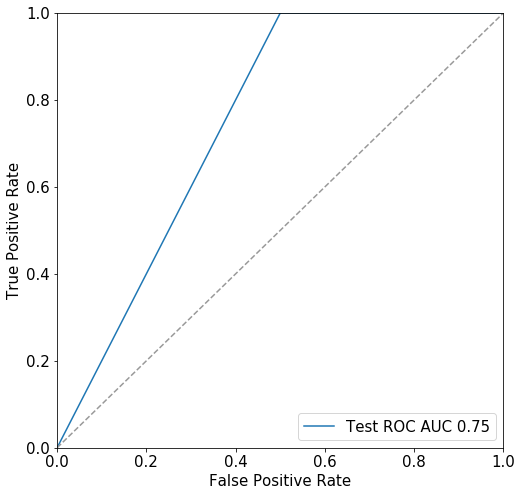

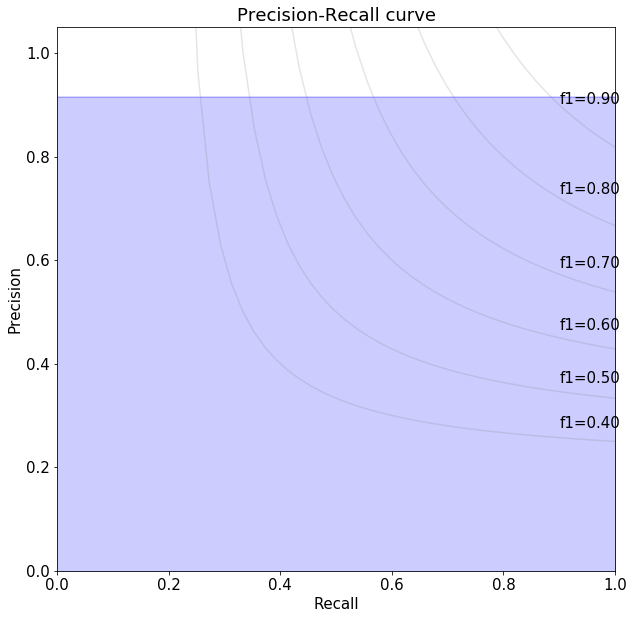

(None, None)

In [537]:
model(LogisticRegression(), km_train_x, km_valid_x,km_train_y,km_valid_y)

In [538]:
# model(LogisticRegression(), m_train_x, m_valid_x,m_train_y,m_valid_y)

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy_score: 0.844
precision_score: 0.121
recall_score: 0.143

confusion_matrix: 

[[  0  20]
 [  0 108]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        20
           1       0.84      1.00      0.92       108

    accuracy                           0.84       128
   macro avg       0.42      0.50      0.46       128
weighted avg       0.71      0.84      0.77       128



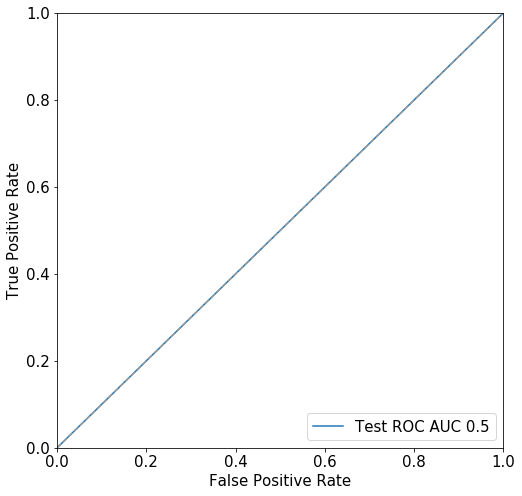

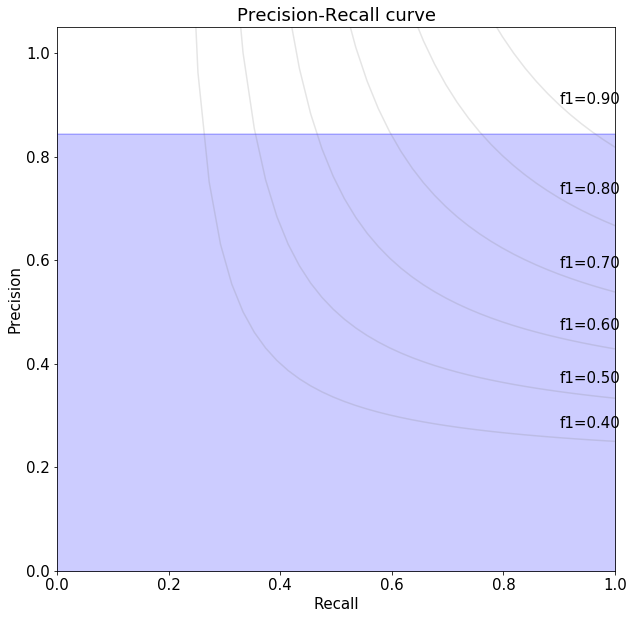

(None, None)

In [539]:
# .naive_bayes
from sklearn.naive_bayes import MultinomialNB
model(MultinomialNB(), km_train_x, km_valid_x,km_train_y,km_valid_y)

C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\au00174\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Accuracy_score: 1.000
precision_score: 0.286
recall_score: 0.286

confusion_matrix: 

[[ 20   0]
 [  0 108]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       1.00      1.00      1.00       108

    accuracy                           1.00       128
   macro avg       1.00      1.00      1.00       128
weighted avg       1.00      1.00      1.00       128



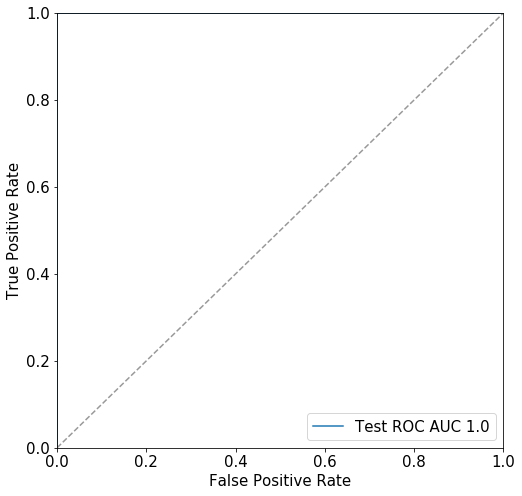

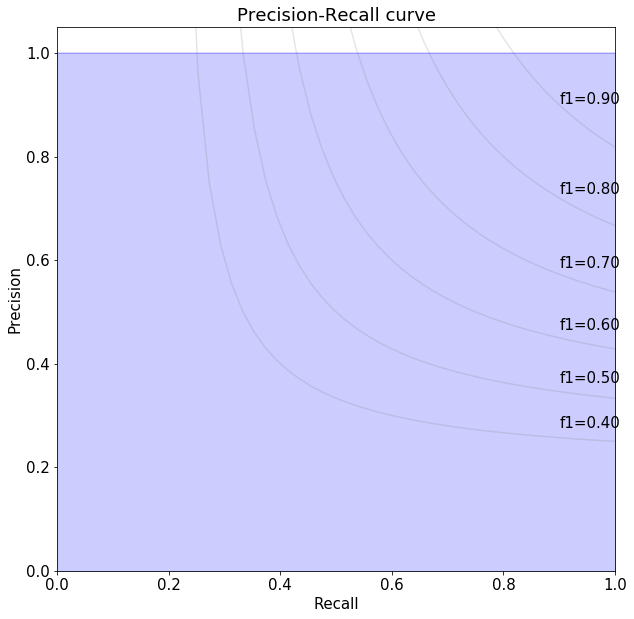

(None, None)

In [540]:
# xgboost
from xgboost import XGBClassifier
model(XGBClassifier(), km_train_x, km_valid_x,km_train_y,km_valid_y)

### вопросы:

    1 как собрать 60000 твитов
    2 косинусное время для кластеризации
    3 логика хода работы
    4 иллюстрации/бизнес метрики табло
    5 как проверить факт
    6 вероятность топ-20 слов 
    7 какая часть работы по причинам оттока
    8 Зачем нужна часть EDA, в которой нет обработки данных